In [ ]:
ki# required imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras import datasets, layers, models



In [ ]:
# to list all the files and dirctories in current directory
!ls

sample_data


In [ ]:
# connection with google drive & changing path

from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/ReemRiad')

Mounted at /content/drive


In [ ]:
# Data Preparation and storing lables
all_files = [] 
Y = []
Y_plus = [] 
root = 'data'
for path, subdirs, files in os.walk(root):
   
    for name in files:
  
        if(path[:17]=="data/CT/Non-COVID"):
          Y_plus.append(0)
        elif(path[:13]=="data/CT/COVID"):
          Y_plus.append(1)
        elif(path[:16]=="data/X-ray/COVID"):
          Y_plus.append(2)
        else:
          Y_plus.append(3)
        if(path[-9:]=="Non-COVID"):
          Y.append(0)
        else:
          
          Y.append(1)
        all_files.append(os.path.join(path, name))

Y = np.array(Y)
all_files = np.array(all_files)
Y_plus = np.array(Y_plus)
Y.shape[0]

17885

In [ ]:

#Train set preparation
import random
test_rate = 0.8
to_pick = int(0.8* Y.shape[0])
print(Y.shape[0]," ", to_pick)
inds = random.sample(range(1, Y.shape[0]), to_pick)
print(inds)
train_mask = np.in1d(np.arange(1, Y.shape[0]), inds)
validation_mask = train_mask == False
train_files = all_files[inds]
y_train = Y[inds]

17885   14308
[94, 7401, 7618, 12118, 9588, 3022, 12974, 6745, 8636, 7583, 1328, 4060, 2741, 11875, 14753, 10298, 13616, 9513, 15185, 13028, 5356, 4883, 4724, 9004, 14563, 12186, 11842, 10046, 9206, 15688, 12559, 10471, 15516, 16432, 14435, 9494, 6678, 13409, 9783, 4455, 2609, 12326, 12471, 10552, 13946, 1436, 17330, 8439, 10407, 6741, 2849, 890, 2958, 11235, 3881, 2299, 16569, 14041, 11218, 6020, 14068, 9071, 15730, 17181, 10015, 3273, 10068, 1257, 4998, 16117, 9710, 10736, 4353, 16008, 9708, 10723, 2707, 352, 12997, 8918, 14370, 13920, 11500, 10819, 4162, 5950, 728, 1994, 4145, 16968, 7858, 13990, 4949, 4254, 987, 3834, 10995, 16510, 8059, 2536, 8072, 4199, 7031, 14620, 4322, 7419, 4409, 10136, 10470, 9311, 5394, 14794, 17810, 135, 1087, 5138, 8823, 3705, 2777, 17675, 7095, 3139, 16674, 5095, 2556, 12217, 11677, 5890, 4640, 16579, 16641, 15980, 3870, 12739, 12856, 11900, 5521, 17343, 3263, 17492, 12686, 4811, 3152, 12510, 6520, 10059, 9360, 14964, 6689, 5202, 14688, 16607, 16234, 875

In [ ]:

# Validation data files & labels 
validation_inds = np.arange(1, Y.shape[0])[validation_mask]
validation_files = all_files[validation_inds]
y_validation = Y[validation_inds]

#Loading validation set
validation_imgs = []
for f in validation_files:
  img = cv2.imread(f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (256, 256)) 
  img = img/255.0
  validation_imgs.append(img)
validation_imgs = np.array(validation_imgs)


In [ ]:
# function that returns a batch of images after apply preprocessing
def get_batch(bs):
  indices = random.sample(range(1, train_files.shape[0]), bs)
  files = train_files[indices]
  yt = y_train[indices]
  imgs = []
  for f in files:
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256, 256)) 
    img = img/255.0
    imgs.append(img)

  return np.array(imgs), yt




In [ ]:
# Model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 115200)            0

In [ ]:
#To Load saved model
model.load_weights("my_model")
validation_imgs = validation_imgs[:2500]
y_validation = y_validation[:2500]

In [ ]:
train_acc = []
train_loss = []
validation_acc = []
validation_loss = []
# Run this cell to start the Training 
batch_size = 64
iters = 500
for i in range(1,iters):
  print("Iteration# ", i+1)
  print()
  X,Y = get_batch(batch_size)
  history_ = model.fit(X, Y, epochs=1, batch_size= batch_size,validation_data=(validation_imgs, y_validation))
  validation_acc.append(history_.history['val_accuracy'])
  validation_loss.append(history_.history['val_loss'])
  train_acc.append(history_.history['accuracy'])
  train_loss.append(history_.history['loss'])
  #Save model after 10 iteration
  #if(i%50 == 0):
model.save("final_model")

  

In [ ]:
ta = [x for xs in train_acc for x in xs]
tl = [x for xs in train_loss for x in xs]
va = [x for xs in validation_acc for x in xs]
vl = [x for xs in validation_loss for x in xs]
import pandas as pd
d = {'Training Accuracy':ta,'Training Loss':tl, 'Validation Accuracy':va, 'Validation Loss':vl}
df = pd.DataFrame(d)
# saving the excel
df.to_excel('training_stats_3.xlsx')
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [ ]:
df= pd.read_excel('training_stats.xlsx', index_col=0)  
df

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss
0,0.515625,0.696288,0.3108,2.617488
1,0.640625,1.360726,0.6892,0.707268
2,0.484375,1.040335,0.7104,0.656523
3,0.515625,0.684192,0.3108,0.935436
4,0.500000,0.759486,0.4632,0.681079
...,...,...,...,...
383,0.953125,0.127600,0.9280,0.190464
384,0.921875,0.215895,0.9304,0.181156
385,0.859375,0.293491,0.9316,0.174963
386,0.953125,0.164141,0.9304,0.171448


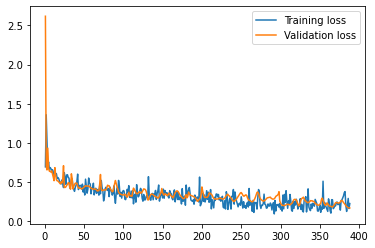

In [ ]:
plt.plot(np.arange(1,389),df['Training Loss'], label="Training loss")
plt.plot(np.arange(1,389),df['Validation Loss'], label="Validation loss")
plt.legend()
plt.show()


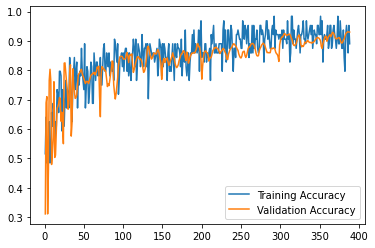

In [ ]:
plt.plot(np.arange(1,389),df['Training Accuracy'], label="Training Accuracy")
plt.plot(np.arange(1,389),df['Validation Accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
test_imgs = []
for f in test_files:
  print(f)
  img = cv2.imread(f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (256, 256)) 
  img = img/255.0
  test_imgs.append(img)
test_imgs = np.array(test_imgs)


In [ ]:
len(train_acc)

20

In [ ]:
#Passing test set through  out trained model
predicted = model.predict(validation_imgs)

In [ ]:
#Prediction based on max probability
pred =np.argmax(predicted, axis=1)

In [ ]:
#Accuracy on Test Set
validation_acc = np.sum(pred==y_validation)/pred.shape[0]
print("Accuracy on Validation set: ",validation_acc)

Accuracy on Validation set:  0.9304


In [ ]:
#Analysis of results
pos_mask = y_validation == 1  #to extract covid positive images of validation set
neg_mask = y_validation == 0  #to extract covid negative images of validation set
pos_accuracy = np.sum(pred[pos_mask] == y_validation[pos_mask]) /np.sum(pos_mask) 
neg_accuracy = np.sum(pred[neg_mask] == y_validation[neg_mask]) /np.sum(neg_mask)

print("Accuracy on COVID positive images: ",pos_accuracy )
print("Accuracy on COVID negative images: ", neg_accuracy)



Accuracy on COVID positive images:  0.9253208868144691
Accuracy on COVID negative images:  0.9414758269720102


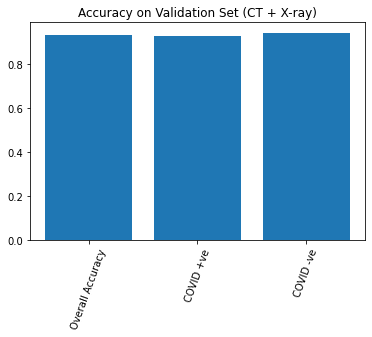

In [ ]:
acc = []
x = np.arange(1,4)
plt.bar(x, height=[validation_acc, pos_accuracy, neg_accuracy])
plt.xticks(x, ['Overall Accuracy','COVID +ve','COVID -ve'],rotation=70);
plt.title("Accuracy on Validation Set (CT + X-ray)")
plt.show()

In [ ]:
# Test data files & labels 
y_test_plus = Y_plus[validation_inds][:2500]


neg_mask_ct = y_test_plus == 0  #to extract CT Covid negative images of test set
pos_mask_ct = y_test_plus == 1  #to extract CT covid positive images of test set
neg_mask_xray = y_test_plus == 3  #to extract X-ray Covid negative images of test set
pos_mask_xray = y_test_plus == 2  #to extract X-ray covid positive images of test set

neg_accuracy_ct = np.sum(pred[neg_mask_ct] == y_validation[neg_mask_ct]) /np.sum(neg_mask_ct) 
pos_accuracy_ct = np.sum(pred[pos_mask_ct] == y_validation[pos_mask_ct]) /np.sum(pos_mask_ct)
neg_accuracy_xray = np.sum(pred[neg_mask_xray] == y_validation[neg_mask_xray]) /np.sum(neg_mask_xray) 
pos_accuracy_xray = np.sum(pred[pos_mask_xray] == y_validation[pos_mask_xray]) /np.sum(pos_mask_xray)

print("Accuracy on CT COVID positive images: ",pos_accuracy_ct )
print("Accuracy on CT COVID negative images: ", neg_accuracy_ct)
print("Accuracy on X-Ray COVID positive images: ",pos_accuracy_xray )
print("Accuracy on X-Ray COVID negative images: ", neg_accuracy_xray)



acc = []
x = np.arange(1,6)
plt.bar(x, height=[validation_acc, pos_accuracy_ct, neg_accuracy_ct, pos_accuracy_xray ,neg_accuracy_xray])
plt.xticks(x, ['Overall Accuracy','CT COVID +ve','CT COVID -ve', 'X-Ray COVID +ve','X-Ray COVID -ve'],rotation=70);
plt.title("Accuracy on Validation Set")
plt.show()